In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.style as st

# Media Coverage Analysis - Occurences
In this notebook, we retrieve all the quotations from the Quotebank datasets (2016 and 2020) that originate from the following three newspapers: NYTimes, Fox News, BBC. 

We then parse for each of these newspapers, whether the quotations include keywords Trump/Clinton (for 2016) and Biden/Trump (for 2020). Finally, we build timelines of these keywords occurences for each of the three aforementioned newspapers in the months leading to the presidential elections in 2016 and 2020 (January - November)

## Part 1: Parse the Data per Newspaper

In [ ]:
# Method to check if a speaker is the list of candidates. 
def check_speaker(speaker, keywords):
    x = re.search(keywords, speaker, re.I)
    return True if x else False

In [ ]:
# Method to check if a keyword occurs in a list of urls. 
def check_urls(urls, keywords):
    for url in urls:
        x = re.search(keywords, url, re.I)
        if x: return True
    return False

In [ ]:
# Method to process a dataframe based on the keywords we are looking for. 
def process_keywords(df, date):
    if date == "2016":
        keywords = "Hillary|Clinton|Kaine|Donald|Trump|Mike|Pence"
    else: 
        keywords = "Joe|Joseph|Kamala|Harris|Biden|Donald|Trump|Mike|Pence"
    df_parsed = df[df["quotation"].str.contains(keywords, regex=True, case=False) 
                             | df['urls'].apply(lambda x: check_urls(x,keywords))
                             | df['speaker'].apply(lambda x: check_speaker(x,keywords))]
    #print(df_parsed)
    return df_parsed

In [ ]:
# Method to process dataframes read from the Quotebank dataset.
def process_dataframes(chunk, year):
    # First we filter the dates of the quotebanks quotations to only keep interval of interest
    day = "08" if year=="2016" else "03"
    dates_filtered_df = chunk.loc[(chunk['date'] >= f'{year}-01-01')
                     & (chunk['date'] < f'{year}-11-{day}')]
    # Filter our three dataframes based on the quotations, urls and speakers from the respective newspapers.
    df_nytimes =  dates_filtered_df[dates_filtered_df["urls"].apply(lambda x: check_urls(x,"nytimes.com"))]
    df_fox =  dates_filtered_df[dates_filtered_df["urls"].apply(lambda x: check_urls(x,"foxnews.com"))]
    df_bbc =  dates_filtered_df[dates_filtered_df["urls"].apply(lambda x: check_urls(x,"bbc.co.uk"))]
    # Now we want to filter each df based on the occurence of keywords in the quotations and urls
    df_nytimes = process_keywords(df_nytimes, date)
    df_fox = process_keywords(df_fox, date)
    df_bbc = process_keywords(df_bbc, date)
    return df_nytimes, df_fox, df_bbc

In [ ]:
PATH="Data/"
dates = ["2016", "2020"]

for date in dates:
    print(f"Processing Year: {date}")
    # Read the quotebank files for 2016 and 2020
    with pd.read_json(f'Quotebank/quotes-{date}.json.bz2', 
                      lines=True, compression='bz2', chunksize=100000) as df_reader:
            i = 0
            for chunk in df_reader:
                if (i*100000)%1000000 == 0:
                    print(f"Processed: {i*100000} quotations")
                # Process the data for each chunk
                df_nytimes, df_fox, df_bbc = process_dataframes(chunk, date)
                if i == 0:
                    df_nytimes.to_csv(f'{PATH}{date}/ny_times_{date}.csv')
                    df_fox.to_csv(f'{PATH}{date}/foxnews_{date}.csv')
                    df_bbc.to_csv(f'{PATH}{date}/bbc_{date}.csv')
                else:
                    df_nytimes.to_csv(f'{PATH}{date}/ny_times_{date}.csv', mode='a', header=False)
                    df_fox.to_csv(f'{PATH}{date}/foxnews_{date}.csv', mode='a', header=False)
                    df_bbc.to_csv(f'{PATH}{date}/bbc_{date}.csv', mode='a', header=False)
                i += 1

## Part 2: Aggregate the quotations on a monthly basis
In this part we want to do some analysis regarding the number of mentions per month for each newspaper.  

In [2]:
#2016
nytimes_2016_df = pd.read_csv("Data/2016/ny_times_2016.zip", compression="zip")
fox_2016_df = pd.read_csv("Data/2016/foxnews_2016.zip", compression="zip")
bbc_2016_df = pd.read_csv("Data/2016/bbc_2016.zip", compression="zip")
# 2020
nytimes_2020_df = pd.read_csv("Data/2020/ny_times_2020.zip", compression="zip")
fox_2020_df = pd.read_csv("Data/2020/foxnews_2020.zip", compression="zip")
bbc_2020_df = pd.read_csv("Data/2020/bbc_2020.zip", compression="zip")

In [3]:
# Format time for 2016
nytimes_2016_df['date'] = pd.to_datetime(nytimes_2016_df['date'])
fox_2016_df['date'] = pd.to_datetime(fox_2016_df['date'])
bbc_2016_df['date'] = pd.to_datetime(bbc_2016_df['date'])
# Format time for 2020
nytimes_2020_df['date'] = pd.to_datetime(nytimes_2020_df['date'])
fox_2020_df['date'] = pd.to_datetime(fox_2020_df['date'])
bbc_2020_df['date'] = pd.to_datetime(bbc_2020_df['date'])

In [4]:
# Add additional column information for plotting 2016
nytimes_2016_df['month'] = nytimes_2016_df['date'].dt.strftime('%b')
nytimes_2016_df['type'] = "NY Times"
fox_2016_df['month'] = fox_2016_df['date'].dt.strftime('%b')
fox_2016_df['type'] = "Fox News"
bbc_2016_df['month'] = bbc_2016_df['date'].dt.strftime('%b')
bbc_2016_df['type'] = "BBC"
# Add additional column information for plotting 2020
nytimes_2020_df['month'] = nytimes_2020_df['date'].dt.strftime('%b')
nytimes_2020_df['type'] = "NY Times"
fox_2020_df['month'] = fox_2020_df['date'].dt.strftime('%b')
fox_2020_df['type'] = "Fox News"
bbc_2020_df['month'] = bbc_2020_df['date'].dt.strftime('%b')
bbc_2020_df['type'] = "BBC"

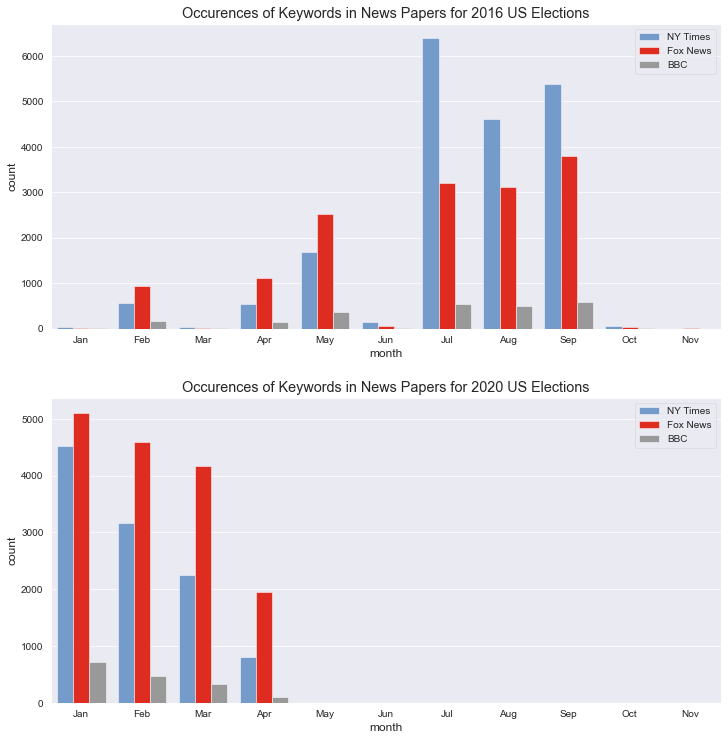

In [25]:
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
df_2016 = pd.concat([nytimes_2016_df, fox_2016_df,bbc_2016_df], ignore_index=True)
df_2020 = pd.concat([nytimes_2020_df, fox_2020_df,bbc_2020_df], ignore_index=True)


sns.set_style("darkgrid")
fig, axs = plt.subplots(2,figsize=(10,10))
fig.tight_layout(h_pad=5)
axs[0].set_title("Occurences of Keywords in News Papers for 2016 US Elections")

sns.countplot(x="month",hue="type",data=df_2016,order=Months, ax=axs[0], palette=['#6699d8',"#fe1100","#999999"])
axs[0].legend(loc='upper right')
axs[1].set_title("Occurences of Keywords in News Papers for 2020 US Elections")
sns.countplot(x="month",hue="type",data=df_2020,order=Months, ax=axs[1], palette=['#6699d8',"#fe1100","#999999"])
axs[1].legend(loc='upper right');

## Part 3: Quandidate Name Distribution

In [ ]:
# Check occurences of Donald Trump in each newspaper in 2016
keywords="Donald|Trump"
df_trump_2016 = df_2016[df_2016["quotation"].str.contains(keywords, regex=True, case=False) 
                         | df_2016['urls'].apply(lambda x: check_urls(x,keywords))
                         | df_2016['speaker'].apply(lambda x: check_speaker(x,keywords))]
df_trump_2020 = df_2020[df_2020["quotation"].str.contains(keywords, regex=True, case=False) 
                         | df_2020['urls'].apply(lambda x: check_urls(x,keywords))
                         | df_2020['speaker'].apply(lambda x: check_speaker(x,keywords))]

In [ ]:
df_trump_2016.to_csv('Data/2016/trump_2016.csv')
df_trump_2020.to_csv('Data/2020/trump_2020.csv')

In [ ]:
# Check occurences of Hillary Clinton in each newspaper in 2016 & Joe Biden in 2020
keywords_2016="Hillary|Clinton"
keywords_2020="Joe|Joseph|Biden"
df_clinton_2016 = df_2016[df_2016["quotation"].str.contains(keywords_2016, regex=True, case=False) 
                         | df_2016['urls'].apply(lambda x: check_urls(x,keywords_2016))
                         | df_2016['speaker'].apply(lambda x: check_speaker(x,keywords_2016))]
df_biden_2020 = df_2020[df_2020["quotation"].str.contains(keywords_2020, regex=True, case=False) 
                         | df_2020['urls'].apply(lambda x: check_urls(x,keywords_2020))
                         | df_2020['speaker'].apply(lambda x: check_speaker(x,keywords_2020))]

In [ ]:
df_clinton_2016.to_csv('Data/2016/clinton_2016.csv')
df_biden_2020.to_csv('Data/2020/biden_2020.csv')

In [ ]:
df_trump_2016.insert(loc=len(df_trump_2016.columns), 
                       column='candidate', value=["Donald Trump"]*df_trump_2016.shape[0])
df_trump_2020.insert(loc=len(df_trump_2020.columns), 
                       column='candidate', value=["Donald Trump"]*df_trump_2020.shape[0])
df_clinton_2016.insert(loc=len(df_clinton_2016.columns), 
                       column='candidate', value=["Hillary Clinton"]*df_clinton_2016.shape[0])
df_biden_2020.insert(loc=len(df_biden_2020.columns), 
                       column='candidate', value=["Joe Biden"]*df_biden_2020.shape[0])

In [13]:
df_trump_2016 = pd.read_csv("Data/2016/trump_2016.zip", compression="zip")
df_trump_2020 = pd.read_csv("Data/2020/trump_2020.zip", compression="zip")
df_clinton_2016 = pd.read_csv("Data/2016/clinton_2016.zip", compression="zip")
df_biden_2020 = pd.read_csv("Data/2020/biden_2020.zip", compression="zip")

In [14]:
# Concatenate the data for plotting
df_candidates_2016 = pd.concat([df_trump_2016, df_clinton_2016], ignore_index=True)
df_candidates_2020 = pd.concat([df_trump_2020, df_biden_2020], ignore_index=True)

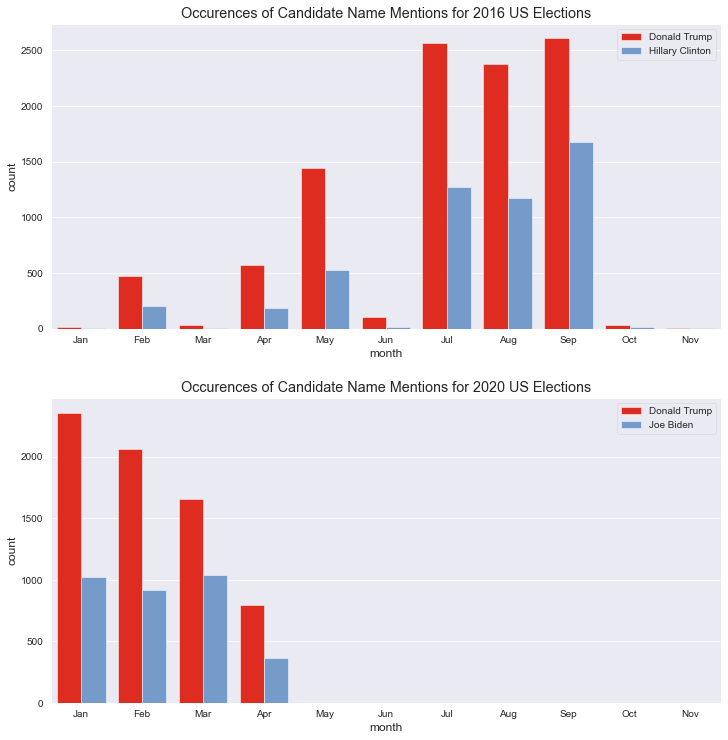

In [28]:
# Plot candidate name mentions distributions
fig, axs = plt.subplots(2,figsize=(10,10))
fig.tight_layout(h_pad=5)
axs[0].set_title("Occurences of Candidate Name Mentions for 2016 US Elections")
sns.countplot(x="month",hue="candidate",data=df_candidates_2016,order=Months, ax=axs[0], palette=["#fe1100",'#6699d8'])
axs[0].legend(loc='upper right')
axs[1].set_title("Occurences of Candidate Name Mentions for 2020 US Elections")
sns.countplot(x="month",hue="candidate",data=df_candidates_2020,order=Months, ax=axs[1], palette=["#fe1100",'#6699d8'])
axs[1].legend(loc='upper right');

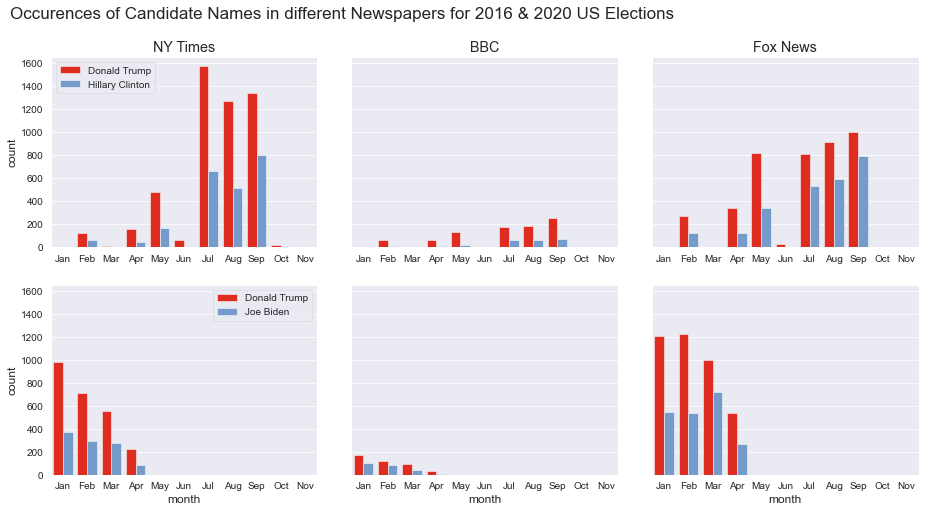

In [67]:
# Plot candidate name mentions distributions
fig, axs = plt.subplots(2,3,figsize=(13,7), sharey=True)

fig.tight_layout(pad=2)
plt.subplots_adjust(top=0.9)
plt.suptitle("Occurences of Candidate Names in different Newspapers for 2016 & 2020 US Elections", x=0, y=1, 
             horizontalalignment='left', verticalalignment='top', fontsize = 17)

axs[0,0].set_title("NY Times")
axs[0,1].set_title("BBC")
axs[0,2].set_title("Fox News")

sns.countplot(x="month",hue="candidate",data=df_candidates_2016[df_candidates_2016.type=="NY Times"],order=Months, ax=axs[0,0], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2016[df_candidates_2016.type=="BBC"],order=Months, ax=axs[0,1], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2016[df_candidates_2016.type=="Fox News"],order=Months, ax=axs[0,2], palette=["#fe1100",'#6699d8'])

axs[0,0].legend(loc='upper left')
axs[0,0].set(xlabel=None)
axs[0,1].legend([],[], frameon=False)
axs[0,1].set(xlabel=None)
axs[0,1].set(ylabel=None)

axs[0,2].legend([],[], frameon=False)
axs[0,2].set(xlabel=None)
axs[0,2].set(ylabel=None)


sns.countplot(x="month",hue="candidate",data=df_candidates_2020[df_candidates_2020.type=="NY Times"],order=Months, ax=axs[1,0], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2020[df_candidates_2020.type=="BBC"],order=Months, ax=axs[1,1], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2020[df_candidates_2020.type=="Fox News"],order=Months, ax=axs[1,2], palette=["#fe1100",'#6699d8'])
axs[1,0].legend(loc='upper right');
axs[1,1].set(ylabel=None)
axs[1,2].set(ylabel=None)
axs[1,1].legend([],[], frameon=False)
axs[1,2].legend([],[], frameon=False);
